# Split Pipeline Demo

This notebook demonstrates the split functions in `ml/data/split.py`:

1. **`split_by_route_polyline_index`** - Split data by (route, polyline_index) for per-polyline training

This function is used by `split_by_polyline_pipeline()` in `ml/pipelines.py`.

In [1]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import split functions
from ml.data.split import split_by_route_polyline_index

print("Split functions loaded successfully!")

2026-02-04 17:21:07 - ml - INFO - ML logging level: debug
Split functions loaded successfully!


---
## `split_by_route_polyline_index`

Splits a DataFrame into multiple DataFrames, one for each unique `(route, polyline_index)` combination.

**Why?** Different polylines (route segments) may have different characteristics. Training separate models per polyline can improve prediction accuracy.

### Function Signature
```python
def split_by_route_polyline_index(
    df: pd.DataFrame,
    route_column: str = 'route',
    polyline_index_column: str = 'polyline_idx'
) -> dict[tuple[str, int], pd.DataFrame]:
```

**Returns a dictionary mapping `(route_name, polyline_index)` tuples to DataFrames.**

In [2]:
# Create sample DataFrame with multiple routes and polylines
df = pd.DataFrame({
    'vehicle_id': [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4],
    'route': [
        'WEST', 'WEST', 'WEST',    # Vehicle 1 on WEST
        'WEST', 'WEST', 'WEST',    # Vehicle 2 on WEST
        'NORTH', 'NORTH', 'NORTH', # Vehicle 3 on NORTH
        'NORTH', 'NORTH', 'NORTH'  # Vehicle 4 on NORTH
    ],
    'polyline_idx': [
        0, 0, 0,  # WEST polyline 0
        1, 1, 1,  # WEST polyline 1
        0, 0, 0,  # NORTH polyline 0
        0, 0, 0   # NORTH polyline 0 (same)
    ],
    'latitude': [42.730, 42.731, 42.732, 42.733, 42.734, 42.735,
                42.736, 42.737, 42.738, 42.739, 42.740, 42.741],
    'longitude': [-73.676, -73.677, -73.678, -73.679, -73.680, -73.681,
                 -73.682, -73.683, -73.684, -73.685, -73.686, -73.687],
    'speed_kmh': [20, 25, 30, 15, 20, 25, 30, 35, 40, 25, 30, 35]
})

print("Original DataFrame:")
print(df)
print(f"\nUnique (route, polyline_idx) combinations:")
print(df.groupby(['route', 'polyline_idx']).size())

Original DataFrame:
    vehicle_id  route  polyline_idx  latitude  longitude  speed_kmh
0            1   WEST             0    42.730    -73.676         20
1            1   WEST             0    42.731    -73.677         25
2            1   WEST             0    42.732    -73.678         30
3            2   WEST             1    42.733    -73.679         15
4            2   WEST             1    42.734    -73.680         20
5            2   WEST             1    42.735    -73.681         25
6            3  NORTH             0    42.736    -73.682         30
7            3  NORTH             0    42.737    -73.683         35
8            3  NORTH             0    42.738    -73.684         40
9            4  NORTH             0    42.739    -73.685         25
10           4  NORTH             0    42.740    -73.686         30
11           4  NORTH             0    42.741    -73.687         35

Unique (route, polyline_idx) combinations:
route  polyline_idx
NORTH  0               6
WEST   

In [3]:
# Split by route and polyline index
polyline_dfs = split_by_route_polyline_index(df, 'route', 'polyline_idx')

print(f"Split into {len(polyline_dfs)} DataFrames:")
print("="*60)
for (route, idx), polyline_df in sorted(polyline_dfs.items()):
    print(f"\n({route}, {idx}): {len(polyline_df)} rows")
    print(polyline_df[['vehicle_id', 'route', 'polyline_idx', 'speed_kmh']])

Split into 3 DataFrames:

(NORTH, 0): 6 rows
    vehicle_id  route  polyline_idx  speed_kmh
6            3  NORTH             0         30
7            3  NORTH             0         35
8            3  NORTH             0         40
9            4  NORTH             0         25
10           4  NORTH             0         30
11           4  NORTH             0         35

(WEST, 0): 3 rows
   vehicle_id route  polyline_idx  speed_kmh
0           1  WEST             0         20
1           1  WEST             0         25
2           1  WEST             0         30

(WEST, 1): 3 rows
   vehicle_id route  polyline_idx  speed_kmh
3           2  WEST             1         15
4           2  WEST             1         20
5           2  WEST             1         25


In [4]:
# Access specific polyline data
west_polyline_0 = polyline_dfs[('WEST', 0)]
print("Accessing polyline_dfs[('WEST', 0)]:")
print(west_polyline_0)

north_polyline_0 = polyline_dfs[('NORTH', 0)]
print("\nAccessing polyline_dfs[('NORTH', 0)]:")
print(north_polyline_0)

Accessing polyline_dfs[('WEST', 0)]:
   vehicle_id route  polyline_idx  latitude  longitude  speed_kmh
0           1  WEST             0    42.730    -73.676         20
1           1  WEST             0    42.731    -73.677         25
2           1  WEST             0    42.732    -73.678         30

Accessing polyline_dfs[('NORTH', 0)]:
    vehicle_id  route  polyline_idx  latitude  longitude  speed_kmh
6            3  NORTH             0    42.736    -73.682         30
7            3  NORTH             0    42.737    -73.683         35
8            3  NORTH             0    42.738    -73.684         40
9            4  NORTH             0    42.739    -73.685         25
10           4  NORTH             0    42.740    -73.686         30
11           4  NORTH             0    42.741    -73.687         35


In [5]:
# Iterate over all polylines
print("Processing each polyline:")
print("="*60)

for (route, idx), polyline_df in sorted(polyline_dfs.items()):
    # Calculate statistics for this polyline
    avg_speed = polyline_df['speed_kmh'].mean()
    num_vehicles = polyline_df['vehicle_id'].nunique()

    print(f"\n{route} Polyline {idx}:")
    print(f"  Rows: {len(polyline_df)}")
    print(f"  Vehicles: {num_vehicles}")
    print(f"  Avg Speed: {avg_speed:.1f} km/h")

Processing each polyline:

NORTH Polyline 0:
  Rows: 6
  Vehicles: 2
  Avg Speed: 32.5 km/h

WEST Polyline 0:
  Rows: 3
  Vehicles: 1
  Avg Speed: 25.0 km/h

WEST Polyline 1:
  Rows: 3
  Vehicles: 1
  Avg Speed: 20.0 km/h


---
## Use Case: Per-Polyline Model Training

The main use case is training separate ML models for each polyline segment.

In [6]:
# Simulate training models per polyline
print("Simulated Per-Polyline Model Training:")
print("="*60)

models = {}
for (route, idx), polyline_df in sorted(polyline_dfs.items()):
    # In real code, you would train an actual model here
    # e.g., train_lstm(polyline_df, ...)

    # For demo, just store basic stats
    models[(route, idx)] = {
        'mean_speed': polyline_df['speed_kmh'].mean(),
        'std_speed': polyline_df['speed_kmh'].std(),
        'n_samples': len(polyline_df)
    }

    print(f"\nTrained model for {route} polyline {idx}:")
    print(f"  Training samples: {len(polyline_df)}")
    print(f"  Mean speed: {models[(route, idx)]['mean_speed']:.1f} km/h")

print(f"\n\nTotal models trained: {len(models)}")

Simulated Per-Polyline Model Training:

Trained model for NORTH polyline 0:
  Training samples: 6
  Mean speed: 32.5 km/h

Trained model for WEST polyline 0:
  Training samples: 3
  Mean speed: 25.0 km/h

Trained model for WEST polyline 1:
  Training samples: 3
  Mean speed: 20.0 km/h


Total models trained: 3


---
## Integration with `split_by_polyline_pipeline`

In `ml/pipelines.py`:

In [7]:
# Show how split_by_polyline_pipeline uses this function
print("""
def split_by_polyline_pipeline(df: pd.DataFrame = None, **kwargs) -> dict[tuple[str, int], pd.DataFrame]:
    from ml.data.split import split_by_route_polyline_index

    # Load preprocessed data if not provided
    if df is None:
        df = preprocess_pipeline(**kwargs)

    # Check required columns
    if 'route' not in df.columns or 'polyline_idx' not in df.columns:
        raise ValueError("Data must have 'route' and 'polyline_idx' columns")

    # Split by polyline
    polyline_dfs = split_by_route_polyline_index(
        df,
        route_column='route',
        polyline_index_column='polyline_idx'
    )

    return polyline_dfs
""")


def split_by_polyline_pipeline(df: pd.DataFrame = None, **kwargs) -> dict[tuple[str, int], pd.DataFrame]:
    from ml.data.split import split_by_route_polyline_index

    # Load preprocessed data if not provided
    if df is None:
        df = preprocess_pipeline(**kwargs)

    # Check required columns
    if 'route' not in df.columns or 'polyline_idx' not in df.columns:
        raise ValueError("Data must have 'route' and 'polyline_idx' columns")

    # Split by polyline
    polyline_dfs = split_by_route_polyline_index(
        df,
        route_column='route',
        polyline_index_column='polyline_idx'
    )

    return polyline_dfs



In [8]:
# Run the actual split_by_polyline_pipeline on real data
from ml.pipelines import split_by_polyline_pipeline, preprocess_pipeline

# First, load preprocessed data
df_real = preprocess_pipeline()
print(f"Loaded {len(df_real):,} preprocessed records")

# Split by polyline
polyline_dfs = split_by_polyline_pipeline(df=df_real)

print(f"\nSplit into {len(polyline_dfs)} polylines:")
print("="*60)
for (route, idx), polyline_df in sorted(polyline_dfs.items()):
    print(f"  {route} polyline {idx}: {len(polyline_df):,} points")

2026-02-04 17:21:12 - ml.cache - INFO - Loading preprocessed data from /Users/joel/eclipse-workspace/shuttletracker-new/ml/cache/shared/locations_preprocessed.csv
2026-02-04 17:21:19 - ml.cache - INFO - Loaded 1833872 records from cache
Loaded 1,833,872 preprocessed records
2026-02-04 17:21:19 - ml.pipelines - INFO - ======================================================================
2026-02-04 17:21:19 - ml.pipelines - INFO - SPLIT BY POLYLINE PIPELINE
2026-02-04 17:21:19 - ml.pipelines - INFO - ======================================================================
2026-02-04 17:21:19 - ml.pipelines - INFO - Splitting 1833872 points by route and polyline index...
2026-02-04 17:21:20 - ml.pipelines - INFO -   ✓ Split into 16 unique polylines:
2026-02-04 17:21:20 - ml.pipelines - INFO -     - NORTH segment 0.0: 141409 points
2026-02-04 17:21:20 - ml.pipelines - INFO -     - NORTH segment 1.0: 79017 points
2026-02-04 17:21:20 - ml.pipelines - INFO -     - NORTH segment 2.0: 50648 poin

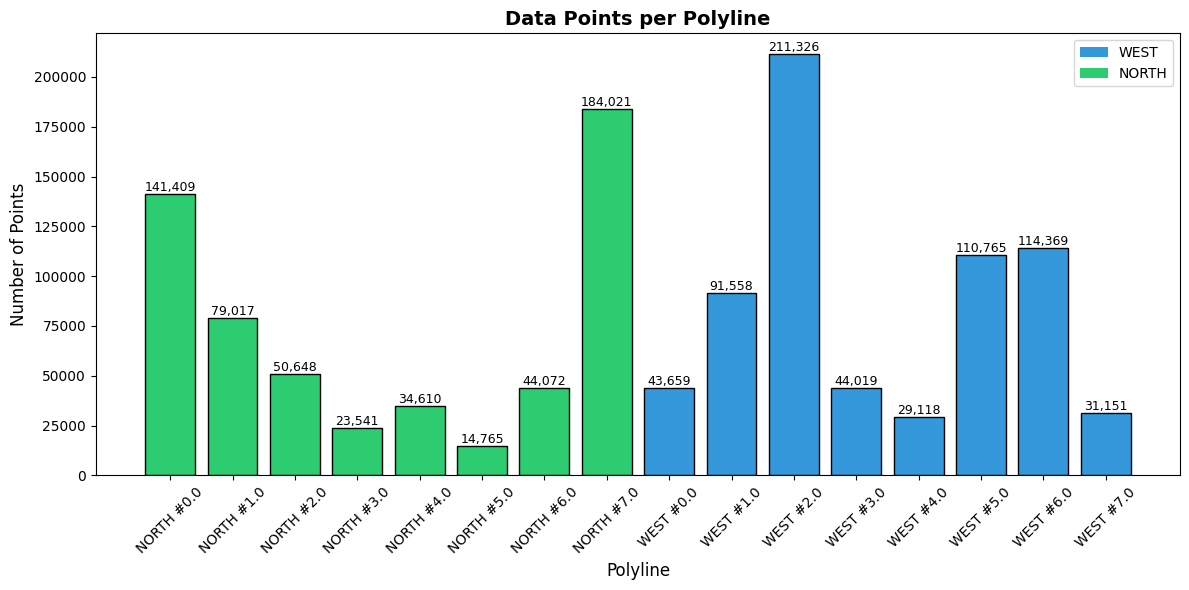

In [9]:
# Visualize polyline sizes
import matplotlib.pyplot as plt

# Get sizes
labels = [f"{r} #{i}" for (r, i) in sorted(polyline_dfs.keys())]
sizes = [len(polyline_dfs[k]) for k in sorted(polyline_dfs.keys())]

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#3498db' if 'WEST' in l else '#2ecc71' for l in labels]
bars = ax.bar(labels, sizes, color=colors, edgecolor='black', linewidth=1)

ax.set_xlabel('Polyline', fontsize=12)
ax.set_ylabel('Number of Points', fontsize=12)
ax.set_title('Data Points per Polyline', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)

# Add value labels
for bar, size in zip(bars, sizes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
           f'{size:,}', ha='center', va='bottom', fontsize=9)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#3498db', label='WEST'),
                   Patch(facecolor='#2ecc71', label='NORTH')]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

---
## Used in LSTM Pipeline

The `lstm_pipeline()` uses this split to train a separate LSTM model for each polyline:

In [10]:
# Show how lstm_pipeline uses the split
print("""
def lstm_pipeline(...) -> dict[tuple[str, int], tuple]:
    # Step 1: Get stops data
    stops_df = stops_pipeline(**kwargs)

    # Step 2: Add ETAs
    eta_df = eta_pipeline(df=stops_df, **kwargs)

    # Step 3: Split by polyline
    polyline_dfs = split_by_polyline_pipeline(df=eta_df)

    # Step 4: Train a model for each polyline
    polyline_models = {}
    for polyline_key, df in polyline_dfs.items():
        route_name, polyline_idx = polyline_key

        # Split train/test
        train_df, test_df = segmented_train_test_split(df, ...)

        # Train model
        model = train_lstm(train_df, ...)

        # Evaluate
        results = evaluate_lstm(model, test_df, ...)

        # Store
        polyline_models[polyline_key] = (model, results)

    return polyline_models
""")


def lstm_pipeline(...) -> dict[tuple[str, int], tuple]:
    # Step 1: Get stops data
    stops_df = stops_pipeline(**kwargs)

    # Step 2: Add ETAs
    eta_df = eta_pipeline(df=stops_df, **kwargs)

    # Step 3: Split by polyline
    polyline_dfs = split_by_polyline_pipeline(df=eta_df)

    # Step 4: Train a model for each polyline
    polyline_models = {}
    for polyline_key, df in polyline_dfs.items():
        route_name, polyline_idx = polyline_key

        # Split train/test
        train_df, test_df = segmented_train_test_split(df, ...)

        # Train model
        model = train_lstm(train_df, ...)

        # Evaluate
        results = evaluate_lstm(model, test_df, ...)

        # Store
        polyline_models[polyline_key] = (model, results)

    return polyline_models



---
## Summary

| Function | Input | Output | Purpose |
|----------|-------|--------|----------|
| `split_by_route_polyline_index` | DataFrame with route + polyline_idx | Dict of DataFrames | Per-polyline training |

**Return type:** `dict[tuple[str, int], pd.DataFrame]`
- Key: `(route_name, polyline_index)` tuple
- Value: DataFrame containing only that polyline's data

**Use case:** Training separate ML models for each route segment to capture location-specific patterns.